<a href="https://colab.research.google.com/github/fraazor/mushroom_classifier/blob/master/mushroom_classifier_V2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook I will build my own image dataset from google and subsequently train a model to classify individual mushroom species. 

This notebook is inspired by Jeremy Howard and his fastai course.

https://www.fast.ai/

In [0]:
from fastai.tabular import *
from fastai.vision import *
import os
import numpy as np
import random

import matplotlib.pyplot as plt

To use images from your Google Drive account you need to mount your notebook.

You will be asked you sign into your Google account, confirm the colab request and copy the authorization code into the pending colab cell.

In [0]:
from google.colab import drive

drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


To download the URL's from a Google image search, copy this javascript code into the developer console after you have made your search.


**urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);**

**window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));**


Name the folders after the google searches you made.

In [0]:
folders = ["amanita_strobiliformis", "boletus_edulis", "chanterelles", "flammulina_velutipes", 
          "fly_agaric", "gyromitra_esculenta", "scleroderma_citrinum"]
files = ["urls_amanita_strobiliformis.csv", "urls_boletus_edulis.csv","urls_chanterelles.csv",
         "urls_flammulina_velutipes.csv", "urls_fly_agaric.csv", "urls_gyromitra_esculenta.csv",
        "urls_scleroderma_citrinum.csv"]

path = Path("./fast_ai_data/mushrooms/")

In [0]:
for folder in folders:
  dest = path/folder
  dest.mkdir(parents=True, exist_ok=True)

In [0]:
path.ls()

[PosixPath('fast_ai_data/mushrooms/scleroderma_citrinum'),
 PosixPath('fast_ai_data/mushrooms/fly_agaric'),
 PosixPath('fast_ai_data/mushrooms/amanita_strobiliformis'),
 PosixPath('fast_ai_data/mushrooms/gyromitra_esculenta'),
 PosixPath('fast_ai_data/mushrooms/flammulina_velutipes'),
 PosixPath('fast_ai_data/mushrooms/boletus_edulis'),
 PosixPath('fast_ai_data/mushrooms/chanterelles')]

The javascript code will download the URLs of the images locally. You can upload them to their respective folders using the "files"-tab in colab.

In [0]:
os.listdir("/content/fast_ai_data/mushrooms/amanita_strobiliformis")

['urls_amanita_strobiliformis.csv']

In [0]:
classes = folders

In [0]:
counter = 0
for folder in folders:
  dest = path/folder
  download_images(path/folder/files[counter], dest, max_pics = 200)
  counter +=1

In [0]:
categories = os.listdir("/content/fast_ai_data/mushrooms")

for folder in categories:
  print(len(os.listdir("/content/fast_ai_data/mushrooms/" + folder)))

195
99
198
100
199
100
101


Check for corrupted images and delete if necessary.

In [0]:
for c in classes: 
  print(c)
  verify_images(path/c, delete=True, max_size = 500)

In [0]:
categories = os.listdir("/content/fast_ai_data/mushrooms")

for folder in categories:
  print(len(os.listdir("/content/fast_ai_data/mushrooms/" + folder)))

187
96
195
98
196
99
96


Around 15-20 images have been removed.
The dataset could be more balanced but it will do for now.

### View data

Create the proper data format and display sample images. We'll use a validation size of 20%.

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train = ".", valid_pct=0.2, 
                                  ds_tfms=get_transforms(), size=224, 
                                  num_workers=4).normalize(imagenet_stats)

In [0]:
data.classes

['amanita_strobiliformis',
 'boletus_edulis',
 'chanterelles',
 'flammulina_velutipes',
 'fly_agaric',
 'gyromitra_esculenta',
 'scleroderma_citrinum']

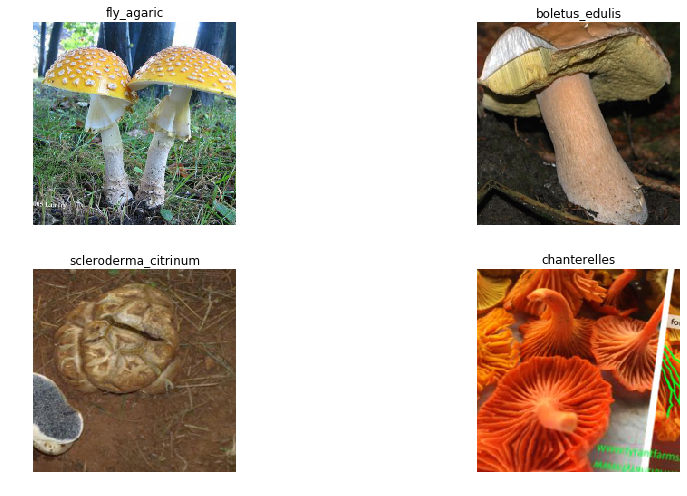

In [0]:
data.show_batch(rows=2, figsize=(15,7))

On previous runs I have already seen that some images contain spaghetti with mushrooms or mushrooms in comic style. These would need to get removed.


In [0]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['amanita_strobiliformis',
  'boletus_edulis',
  'chanterelles',
  'flammulina_velutipes',
  'fly_agaric',
  'gyromitra_esculenta',
  'scleroderma_citrinum'],
 7,
 757,
 189)

We'll download a pre-trained resnet34 (https://docs.fast.ai/vision.models.html).

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 60.1MB/s]


I'm using the one_cycle approach in this notebook. Read about it here: https://arxiv.org/pdf/1803.09820.pdf

In [0]:
learn.fit_one_cycle(6)

epoch,train_loss,valid_loss,accuracy,time
0,2.373442,0.483246,0.825397,00:15
1,1.343212,0.177841,0.931217,00:14
2,0.902374,0.185331,0.947090,00:13
3,0.662521,0.170750,0.957672,00:13
4,0.507845,0.173317,0.952381,00:14
5,0.402912,0.170322,0.952381,00:14


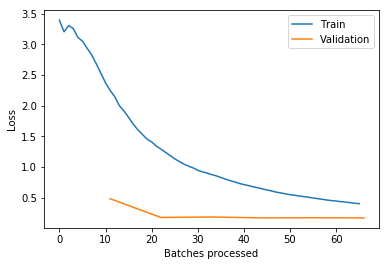

In [0]:
learn.recorder.plot_losses()

After some experimentation with the amount of epochs, this model already shows 95.2% accuracy. 
We'll save the models parameters and try to increase its accuracy by optimizing the learning rate.

In [0]:
learn.save("/content/gdrive/My Drive/Colab Notebooks/mush_stage_1")

In [0]:
learn.unfreeze()

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


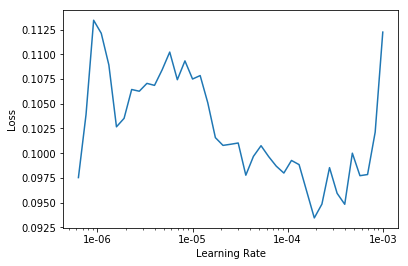

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(2, max_lr=slice(4e-05, 1e-04))

epoch,train_loss,valid_loss,accuracy,time
0,0.101577,0.146861,0.957672,00:14
1,0.087538,0.146668,0.957672,00:14


By optimizing the learning rate we increased accuracy to 95.7%.

In [0]:
learn.save("/content/gdrive/My Drive/Colab Notebooks/mush_stage_2")

### Interpretation

We are taking a look at what the model got wrong to determine what we could improve on.

In [0]:
learn.load("/content/gdrive/My Drive/Colab Notebooks/mush_stage_2")

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

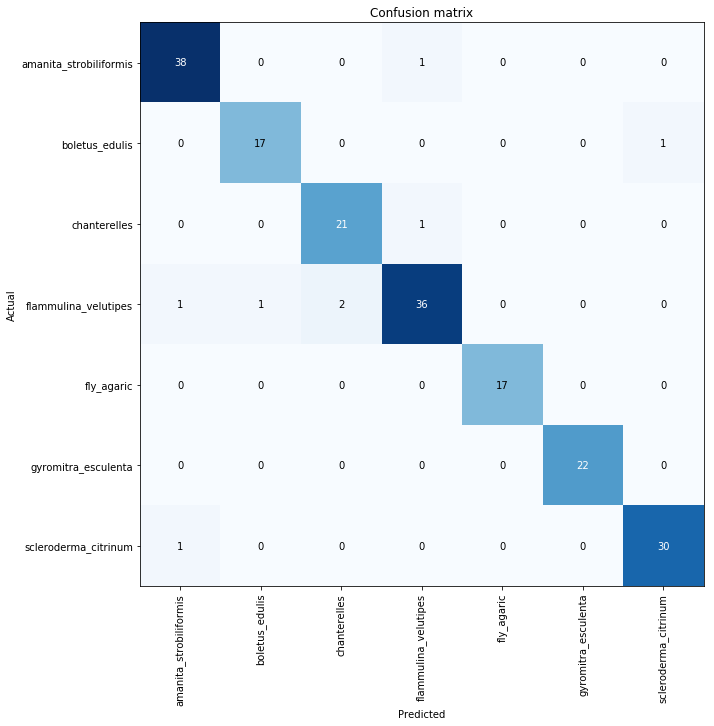

In [0]:
interp.plot_confusion_matrix(figsize=(10,10))

In [0]:
interp.most_confused()

[('flammulina_velutipes', 'chanterelles', 2),
 ('amanita_strobiliformis', 'flammulina_velutipes', 1),
 ('boletus_edulis', 'scleroderma_citrinum', 1),
 ('chanterelles', 'flammulina_velutipes', 1),
 ('flammulina_velutipes', 'amanita_strobiliformis', 1),
 ('flammulina_velutipes', 'boletus_edulis', 1),
 ('scleroderma_citrinum', 'amanita_strobiliformis', 1)]

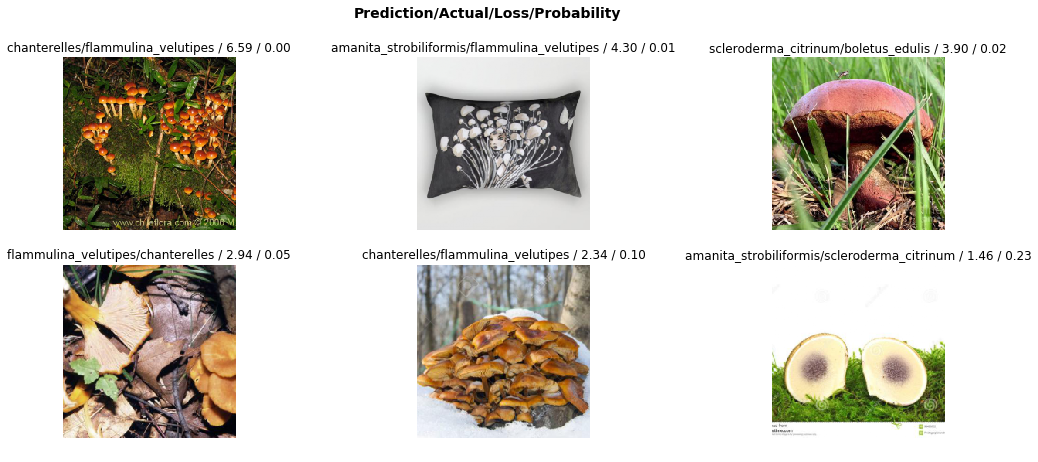

In [0]:
interp.plot_top_losses(6, figsize=(18,7), heatmap = False)

One of the most confusing images to the model is not a mushroom but a pillow. 
Cleaning the dataset further would seem like a good idea.

To see what part of an image makes the model make a classification decision we can use a heatmap.

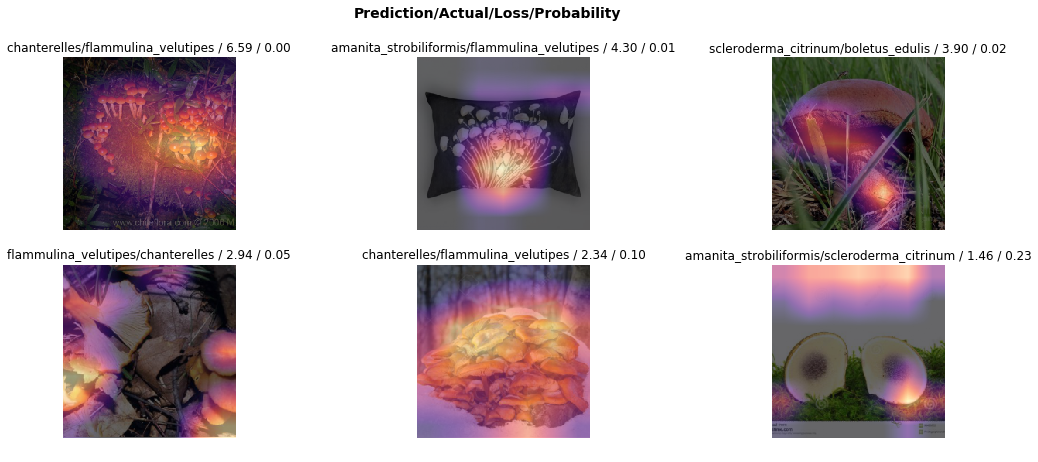

In [0]:
interp.plot_top_losses(6, figsize=(18,7), heatmap = True)

Apparently the white space on the last image threw of the model quite a bit.

### Inference

Predicting the species on a new image

In [0]:
learn.export()

You can use the CPU instead of colab's GPU for this.

In [0]:
defaults.device = torch.device("cpu")

In [0]:
folders

['amanita_strobiliformis',
 'boletus_edulis',
 'chanterelles',
 'flammulina_velutipes',
 'fly_agaric',
 'gyromitra_esculenta',
 'scleroderma_citrinum']

chanterelles


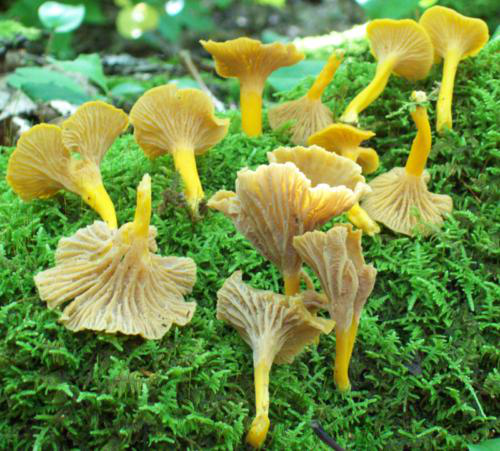

In [0]:
folder_sample = folders[2]
dir_folder_0 = os.listdir("/content/fast_ai_data/mushrooms/" + folder_sample)[0]

img = open_image("/content/fast_ai_data/mushrooms/" + folder_sample + "/" + dir_folder_0)

print(folder_sample)
img

In [0]:
learn = load_learner(path)

In [0]:
pred_class, pred_idx, outputs = learn.predict(img)

outputs_flat = outputs.squeeze().tolist()

In [0]:
for i in range(len(data.classes)):
  if outputs_flat[i] > 0.5:
    print("Probability: {0} \t Class: {1} \t is the predicted category".format(outputs_flat[i],data.classes[i]))
  else:
    print("Probability: {0} \t Class: {1}".format(outputs_flat[i],data.classes[i]))

Probability: 1.6921763972277404e-06 	 Class: amanita_strobiliformis
Probability: 3.5457060221233405e-07 	 Class: boletus_edulis
Probability: 0.9417070746421814 	 Class: chanterelles 	 is the predicted category
Probability: 0.05817939341068268 	 Class: flammulina_velutipes
Probability: 2.7886040697922e-05 	 Class: fly_agaric
Probability: 2.007596594921779e-05 	 Class: gyromitra_esculenta
Probability: 6.355873483698815e-05 	 Class: scleroderma_citrinum


### Done

We correctly classified the chanterelles with 94.1% certainty.

To improve even further we could try:

*   Use more data
*   Add more species
*   Remove misleading images
*   Balance the dataset
*   Change model architecture
*   Other hyperparameter optimization
*   Custom data augmentation via image processing/filtering
*   etc.


